In [2]:
import pandas as pd
import os

In [4]:
op_list = os.listdir(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\\')
op = pd.read_csv(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\20220101.csv', encoding='big5', index_col=False)
for o in op_list:
    if o == '20220101.csv':
        continue
    data = pd.read_csv(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\\' + o, encoding='big5', index_col=False, dtype=str)
    data = data[data['契約'] == 'TXO']
    op = pd.concat([op, data], axis=0)
op.loc[:, '交易日期'] = pd.to_datetime(op.loc[:, '交易日期'])
op['未沖銷契約數'].replace('-', 0, inplace=True)
op.loc[:, '未沖銷契約數'] = op['未沖銷契約數'].astype(int)

In [109]:
call = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\Option\外資.xlsx', sheet_name='CALL', header=4)
call.set_index('日期', inplace=True)
call.columns = call.columns + '_call'
put = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\Option\外資.xlsx', sheet_name='PUT', header=4)
put.set_index('日期', inplace=True)
put.columns = put.columns + '_put'


In [8]:
group = op.groupby(['交易日期', '到期月份(週別)'], group_keys=True)


In [9]:
import numpy as np
op['CP'] = np.where(op['買賣權']=='買權', 1, -1)
strike_list = list()
op['履約價'] = op['履約價'].astype(float)
for x in range(6000, 19000, 50):
    op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
    op.loc[:, str(x)].where(op.loc[:, str(x)] > 0, 0, inplace=True) 
    strike_list.append(str(x))

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_3780\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_3780\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_3780\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [10]:
maxpain = op.groupby(['交易日期', '到期月份(週別)'])[strike_list].sum()

In [11]:
pain_list = list()
for s in op['到期月份(週別)'].unique():
    for d in op['交易日期'].unique():
        try:
            print(s, d, maxpain.loc[d, s].idxmin())
            pain_list.append((d, s, maxpain.loc[d, s].idxmin()))
        except Exception as e:
            pass

202201W1 2022-01-03T00:00:00.000000000 18300
202201W1 2022-01-04T00:00:00.000000000 18400
202201W1 2022-01-05T00:00:00.000000000 18450
202201W1 2021-12-29T00:00:00.000000000 18300
202201W1 2021-12-30T00:00:00.000000000 18250
202201   2022-01-03T00:00:00.000000000 17900
202201   2022-01-04T00:00:00.000000000 18000
202201   2022-01-05T00:00:00.000000000 18000
202201   2022-01-06T00:00:00.000000000 18000
202201   2022-01-07T00:00:00.000000000 18000
202201   2022-01-10T00:00:00.000000000 18000
202201   2022-01-11T00:00:00.000000000 18000
202201   2022-01-12T00:00:00.000000000 18100
202201   2022-01-13T00:00:00.000000000 18200
202201   2022-01-14T00:00:00.000000000 18300
202201   2021-10-21T00:00:00.000000000 15500
202201   2021-10-22T00:00:00.000000000 16600
202201   2021-10-25T00:00:00.000000000 16700
202201   2021-10-26T00:00:00.000000000 16700
202201   2021-10-27T00:00:00.000000000 16800
202201   2021-10-28T00:00:00.000000000 16800
202201   2021-10-29T00:00:00.000000000 16900
202201   2

In [17]:
import pymongo
client = pymongo.MongoClient()
db = client['Index']
twse = pd.DataFrame(db['TWA00'].find({}, {'_id': 0})).set_index('日期')

In [18]:
df = pd.DataFrame(pain_list)
df[2] = df[2].astype(int)

In [64]:
df[1] = df[1].apply(lambda x: x.strip() + 'W3' if '  ' in x else x)

In [65]:
df1 = df.sort_values([0, 1]).drop_duplicates(subset=[0], keep='first')

In [66]:
df1.set_index(0, inplace=True)

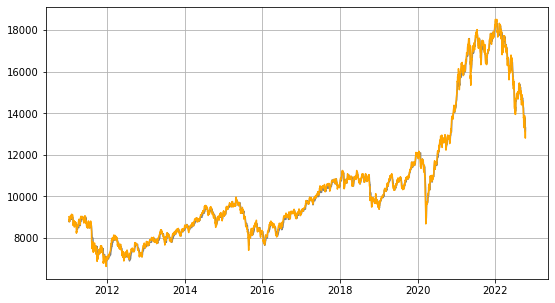

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(df1[2].shift(1), color='grey')
ax.plot(twse['還原收盤價']['2011':], color='orange')
ax.grid()
plt.show()

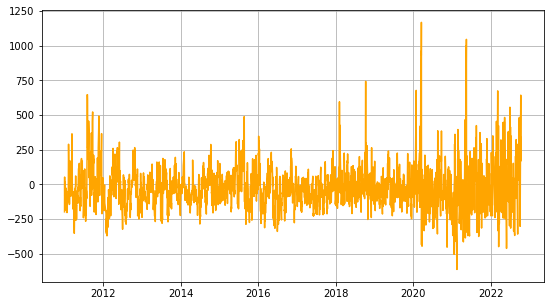

In [23]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(df1[2].shift(1) - twse['還原收盤價']['2011':], color='orange')
ax.grid()
plt.show()

In [24]:
(df1[2].shift(1) - twse['還原收盤價']['2011':]).groupby(pd.Grouper(freq='y')).describe()

,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
2011-12-31,246.0,15.220813,177.626208,-351.98,-118.2425,-19.260,115.5650,647.20
2012-12-31,250.0,-45.941040,133.951069,-369.91,-135.8825,-43.830,43.7200,305.34
2013-12-31,246.0,-40.332439,97.881269,-279.54,-111.4875,-33.925,21.4050,195.74
2014-12-31,248.0,-36.967823,95.506149,-284.96,-101.8900,-45.000,11.1950,288.61
2015-12-31,244.0,7.456025,119.650667,-286.92,-66.5825,-4.985,81.7575,489.66
2016-12-31,244.0,-47.888893,131.020808,-338.24,-129.1850,-53.595,35.3375,347.94
2017-12-31,246.0,-55.070366,88.382508,-226.84,-120.2575,-58.105,6.6025,244.24
2018-12-31,247.0,0.683036,121.376851,-252.13,-80.9550,-15.390,61.0150,743.89
2019-12-31,242.0,-29.217231,91.543018,-247.01,-91.4250,-34.010,20.1050,241.71


In [213]:

data = pd.concat([df1[2], twse['還原收盤價']['2011':], put['未平倉口數買賣淨額_put'], call['未平倉口數買賣淨額_call'], put['未平倉契約金額買賣淨額(千)_put'], call['未平倉契約金額買賣淨額(千)_call']], axis=1)
#data['未平倉契約金額買賣淨額(千)'] = data['未平倉契約金額買賣淨額(千)']*-1,

In [246]:
data.rename({2: 'MaxPain'}, inplace=True, axis=1)
data['差值'] = data.iloc[:, 1] - data.iloc[:, 0]
data.iloc[-20:, [1, 0, -1]]

,還原收盤價,MaxPain,差值
2022-09-16,14561.76,14650,-88.24
2022-09-19,14425.68,14600,-174.32
2022-09-20,14549.30,14600,-50.70
2022-09-21,14424.52,14500,-75.48
2022-09-22,14284.63,14350,-65.37
2022-09-23,14118.38,14250,-131.62
2022-09-26,13778.19,14000,-221.81
2022-09-27,13826.59,13950,-123.41
2022-09-28,13466.07,13700,-233.93
2022-09-29,13534.26,13550,-15.74


In [244]:
data

,2,還原收盤價,未平倉口數買賣淨額_put,未平倉口數買賣淨額_call,未平倉契約金額買賣淨額(千)_put,未平倉契約金額買賣淨額(千)_call,差值
2011-01-03,8800,9025.30,230173,213719,290293,1614062,225.30
2011-01-04,8900,8997.19,230543,226165,333974,1438293,97.19
2011-01-05,8800,8846.31,231015,240906,456206,1076693,46.31
2011-01-06,8800,8883.21,237324,245060,426976,1136829,83.21
2011-01-07,8800,8782.72,246367,249698,586863,887875,-17.28
...,...,...,...,...,...,...,...
2022-10-07,13750,13702.28,31490,23788,607471,48196,-47.72
2022-10-11,13300,13106.03,28946,27835,749504,60569,-193.97
2022-10-12,13150,13081.24,24879,26209,673816,54907,-68.76
2022-10-13,13300,12810.73,23686,32823,767900,64097,-489.27


In [214]:
(data['還原收盤價'].shift(-1) - data[2])#[(data.iloc[:, -1]).gt(data.iloc[:, -1].rolling(20).mean())].describe()

2011-01-03    197.19
2011-01-04    -53.69
2011-01-05     83.21
2011-01-06    -17.28
2011-01-07     17.88
               ...  
2022-10-07   -643.97
2022-10-11   -218.76
2022-10-12   -339.27
2022-10-13   -171.88
2022-10-14       NaN
Length: 2894, dtype: float64

In [215]:
(data['還原收盤價'].shift(-1) - data[2]).rolling(10).std().corr((put['未平倉契約金額買賣淨額(千)_put']).rolling(10).std())

0.48590121623405935

In [216]:
d1 = (data['還原收盤價'].shift(-1) - data[2]).rolling(10).std()
d2 = (data['未平倉契約金額買賣淨額(千)_put']).rolling(10).std()
d3 = (data['未平倉契約金額買賣淨額(千)_put'] - data['未平倉契約金額買賣淨額(千)_call'])
# d1 = (d1 - d1.rolling(200).mean()) / d1.rolling(200).std()
# d2 = (d2 - d2.rolling(200).mean()) / d2.rolling(200).std()

In [218]:
d1.corr(d3)

0.5216379710581427

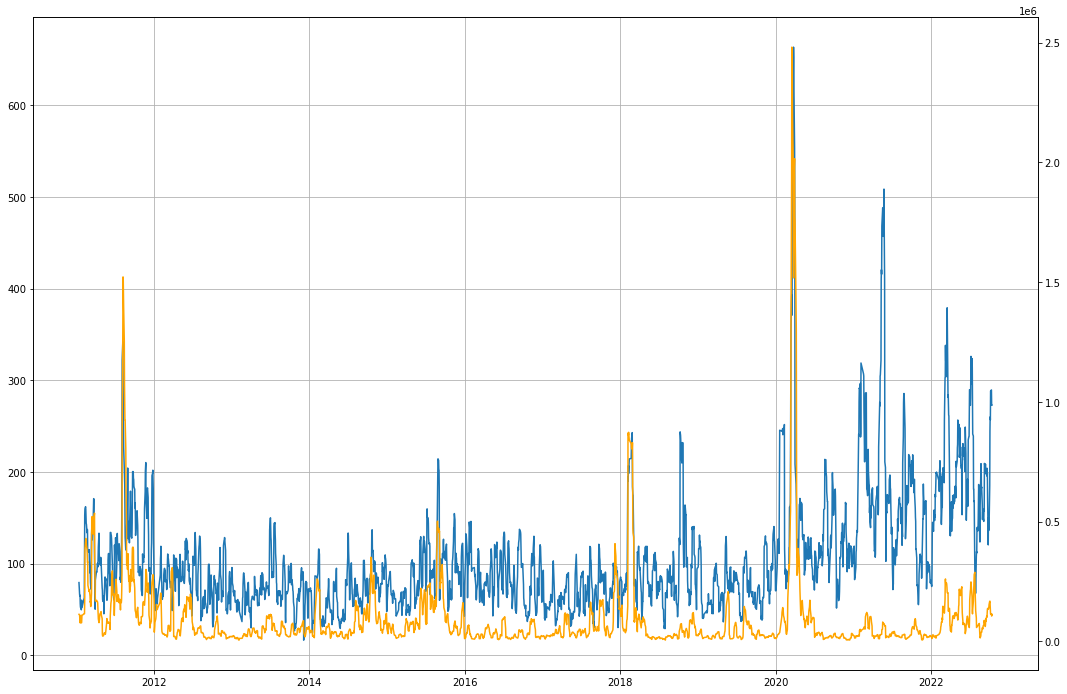

In [219]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(d1)
ax1 = ax.twinx()
ax1.plot(d2, color='orange')
ax.grid()
plt.show()

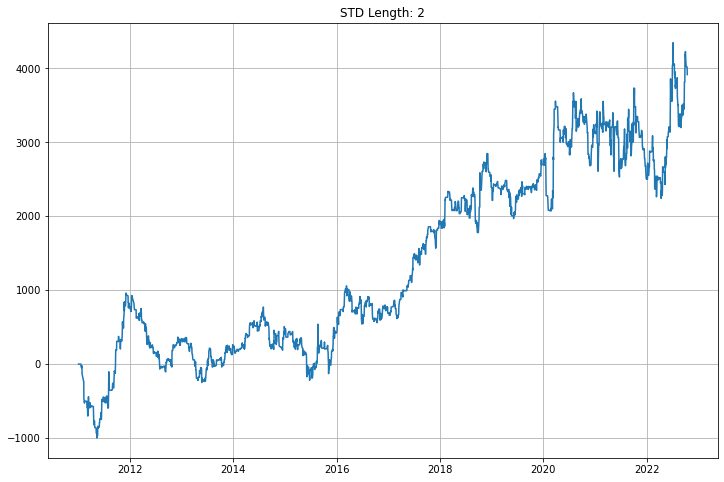

In [248]:
# 對隔日波動的預期相關性 51% 
bs = [0]
#data = data / data.rolling(x).std()
for i in range(1, len(d2)):
    if (d2.iloc[i] > d2.iloc[i-1]) & (d3.iloc[i] < 0):
        bs.append(1)
    elif (d2.iloc[i] > d2.iloc[i-1]) & (d3.iloc[i] > 0):
        bs.append(-1)
    else:
        bs.append(0)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(((twse['還原收盤價'] - twse['還原開盤價']).shift(-1)['2011':] * bs).cumsum())
ax.set_title(f'STD Length: {x}')
ax.grid()
plt.show()

In [223]:
d2

2011-01-03              NaN
2011-01-04              NaN
2011-01-05              NaN
2011-01-06              NaN
2011-01-07              NaN
                  ...      
2022-10-07    112966.375706
2022-10-11    113375.813267
2022-10-12    105151.673967
2022-10-13    107462.373502
2022-10-14    112033.747325
Name: 未平倉契約金額買賣淨額(千)_put, Length: 2894, dtype: float64